In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from football_sim import *
import os
plt.rcParams['figure.figsize']=[16,9]

In [2]:
urls = {'EN': 'http://www.football-data.co.uk/mmz4281/1718/E0.csv',
                          'ES': 'http://www.football-data.co.uk/mmz4281/1718/SP1.csv',
                          'IT': 'http://www.football-data.co.uk/mmz4281/1718/I1.csv',
                          'FR': 'http://www.football-data.co.uk/mmz4281/1718/F1.csv',
                          'DE': 'http://www.football-data.co.uk/mmz4281/1718/D1.csv',
                          'NL': 'http://www.football-data.co.uk/mmz4281/1718/N1.csv'
                          }

urls1617 = {'EN': 'http://www.football-data.co.uk/mmz4281/1617/E0.csv',
                          'ES': 'http://www.football-data.co.uk/mmz4281/1617/SP1.csv',
                          'IT': 'http://www.football-data.co.uk/mmz4281/1617/I1.csv',
                          'FR': 'http://www.football-data.co.uk/mmz4281/1617/F1.csv',
                          'DE': 'http://www.football-data.co.uk/mmz4281/1617/D1.csv',
                          'NL': 'http://www.football-data.co.uk/mmz4281/1617/N1.csv'
                          }


In [3]:
all_data1617=get_data(urls1617)
all_data=get_data(urls)
#all_data['EN']=add_match(all_data['EN'],'Liverpool',2,'Newcastle',0)
#all_data['EN']=add_match(all_data['EN'],'Tottenham',2,'Huddersfield',0)
#all_data['EN']=add_match(all_data['EN'],'Brighton',2,'Arsenal',1)
#all_data['EN']=add_match(all_data['EN'],'Man City',1,'Chelsea',0)
#all_data['EN']=add_match(all_data['EN'],'Man United',2,'Liverpool',1)
all_data['EN'].tail(10)

,Date,HomeTeam,AwayTeam,FTHG,FTAG
294,2018-10-03,Newcastle,Southampton,3,0
295,2018-10-03,West Brom,Leicester,1,4
296,2018-10-03,West Ham,Burnley,0,3
297,2018-11-03,Arsenal,Watford,3,0
298,2018-11-03,Bournemouth,Tottenham,1,4
299,2018-12-03,Stoke,Man City,0,2
300,2018-03-17,Bournemouth,West Brom,2,1
301,2018-03-17,Huddersfield,Crystal Palace,0,2
302,2018-03-17,Liverpool,Watford,5,0
303,2018-03-17,Stoke,Everton,1,2


In [4]:
calibrator_1617=Calibrator('calibration_1617.pkl')
for _country in all_data1617:
    calibrator_1617.process_data(all_data1617[_country],_country)

calibration_1617.pkl  exists.
file exists, loading
2132


In [5]:
calibrator=Calibrator('calibration.pkl',old_teams=calibrator_1617.teams)
for _country in all_data:
    calibrator.process_data(all_data[_country],_country)
teams=calibrator.teams

calibration.pkl  exists.
file exists, loading
1673


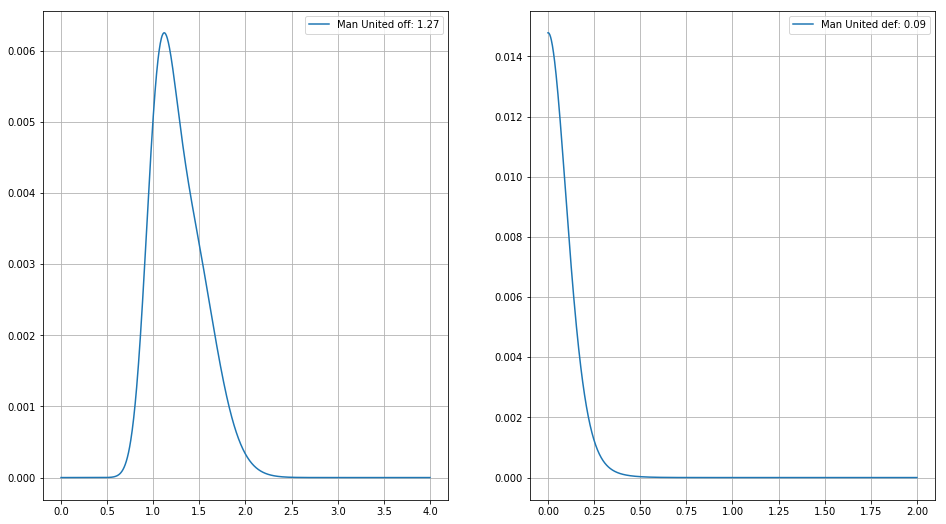

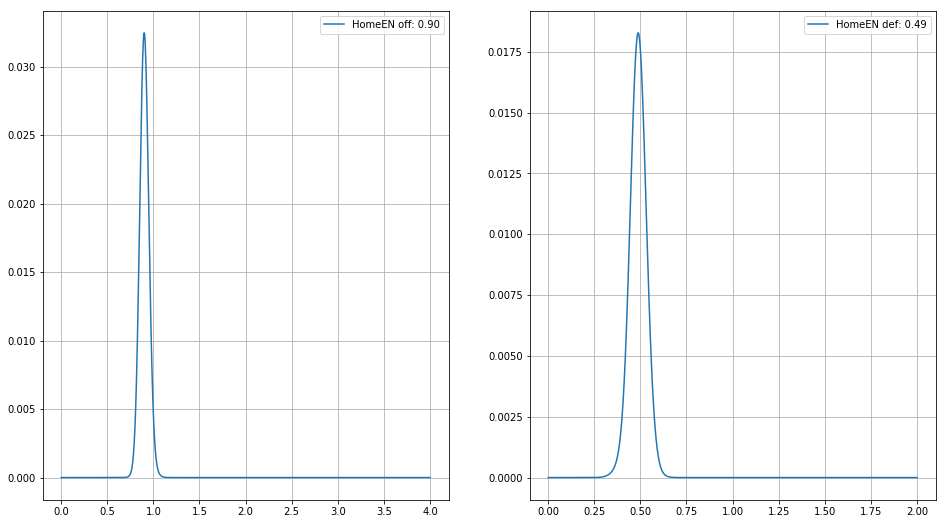

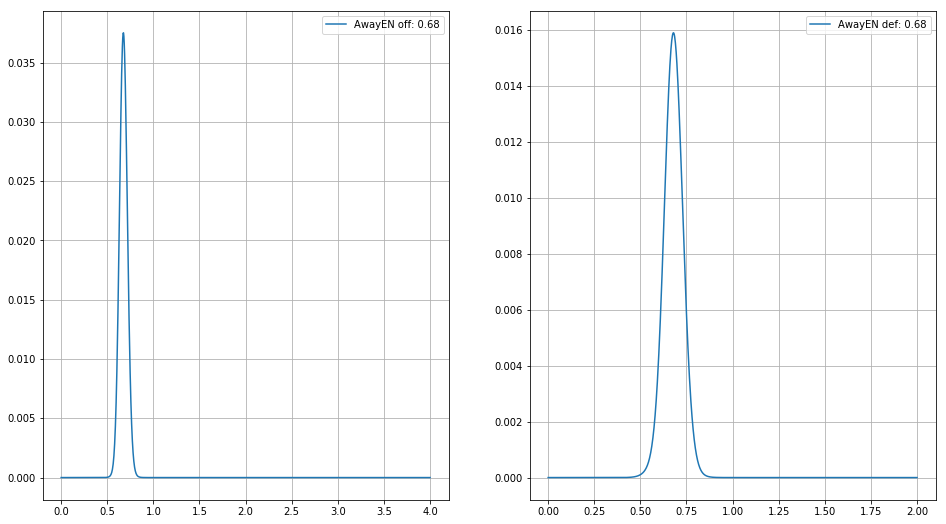

In [6]:
country='EN'
plt.rcParams['figure.figsize']=[16,9]
calibrator.teams['Man United'].plt()
calibrator.teams['Home'+country].plt()
calibrator.teams['Away'+country].plt();

In [7]:
Teams=dict()
League=dict()

In [27]:
country='EN'
home_advantage=np.array(calibrator.teams['Home'+country].means())-np.array(calibrator.teams['Away'+country].means())
print(home_advantage)
Teams[country]={x:teams[x] for x in teams if teams[x].country==country}
League[country]=Season(Teams[country],home_advantage=home_advantage)
League[country].process_current_results(all_data[country])
League[country].simulate_season(n_scenarios=1000000)
League[country].season_report()

[ 0.22650972 -0.19159251]
simulation not yet processed, processing


,Points (mean),Points (low),Points (high),Place (low),Place (high),Win,CL,Off,Deff,Degr
Man City,100.0,95,105,1,1,100.0,100.00,2.24,0.14,0.00
Man United,80.8,75,86,4,2,0.0,98.42,1.27,0.09,0.00
Liverpool,78.0,73,82,5,2,0.0,93.53,1.69,0.24,0.00
Tottenham,77.4,72,83,5,2,0.0,89.26,1.53,0.08,0.00
Chelsea,71.8,66,77,5,4,0.0,18.75,1.37,0.12,0.00
Arsenal,63.4,58,69,6,6,0.0,0.04,1.36,0.39,0.00
Burnley,54.3,49,60,9,7,0.0,0.00,0.46,0.17,0.00
Leicester,51.4,46,57,10,7,0.0,0.00,0.90,0.57,0.00
Everton,49.3,44,55,11,7,0.0,0.00,0.77,0.59,0.00
Watford,44.3,39,49,15,9,0.0,0.00,0.73,0.81,0.12


In [28]:
country='IT'
home_advantage=np.array(calibrator.teams['Home'+country].means())-np.array(calibrator.teams['Away'+country].means())
print(home_advantage)
Teams[country]={x:teams[x] for x in teams if teams[x].country==country}
League[country]=Season(Teams[country],home_advantage=home_advantage)
League[country].process_current_results(all_data[country])
League[country].simulate_season(n_scenarios=100000)
League[country].season_report()

[0.30999241 0.18051017]
simulation not yet processed, processing


,Points (mean),Points (low),Points (high),Place (low),Place (high),Win,CL,Off,Deff,Degr
Juventus,93.8,88,99,2,1,64.75,100.00,1.60,0.05,0.00
Napoli,92.0,86,98,2,1,35.25,100.00,1.71,0.12,0.00
Roma,76.3,70,82,5,3,0.00,89.99,1.26,0.13,0.00
Inter,72.6,66,79,6,3,0.00,63.03,1.23,0.26,0.00
Lazio,70.4,64,76,6,3,0.00,40.94,1.55,0.45,0.00
Milan,65.5,59,72,8,5,0.00,4.98,0.94,0.31,0.00
Atalanta,61.7,55,68,9,5,0.00,0.98,1.04,0.21,0.00
Sampdoria,57.8,51,65,10,6,0.00,0.07,1.03,0.62,0.00
Fiorentina,55.9,49,63,10,7,0.00,0.01,0.92,0.40,0.00
Torino,49.3,43,56,13,9,0.00,0.00,0.91,0.60,0.00


In [10]:
country='NL'
home_advantage=np.array(calibrator.teams['Home'+country].means())-np.array(calibrator.teams['Away'+country].means())
print(home_advantage)
Teams[country]={x:teams[x] for x in teams if teams[x].country==country}
League[country]=Season(Teams[country],home_advantage=home_advantage,nr_cl=2)
League[country].process_current_results(all_data[country])
League[country].simulate_season(n_scenarios=100000)
League[country].season_report()

[ 0.12427812 -0.25266424]
simulation not yet processed, processing


,Points (mean),Points (low),Points (high),Place (low),Place (high),Win,CL,Off,Deff,Degr
PSV Eindhoven,83.8,79,89,2,1,93.12,99.98,1.78,0.10,0.00
Ajax,76.7,72,82,2,1,6.87,97.44,1.94,0.17,0.00
AZ Alkmaar,68.2,63,73,3,3,0.01,2.57,1.20,0.33,0.00
Feyenoord,60.4,55,66,5,4,0.00,0.00,1.44,0.20,0.00
Utrecht,58.1,53,63,6,4,0.00,0.00,1.08,0.35,0.00
Vitesse,52.7,48,58,7,5,0.00,0.00,1.02,0.36,0.00
Zwolle,48.6,44,53,10,6,0.00,0.00,0.66,0.59,0.00
Den Haag,45.3,41,50,11,7,0.00,0.00,0.60,0.64,0.00
Heerenveen,44.2,39,49,12,7,0.00,0.00,0.95,0.69,0.00
Heracles,43.7,39,49,12,7,0.00,0.00,0.90,0.88,0.00


In [11]:
country='ES'
home_advantage=np.array(calibrator.teams['Home'+country].means())-np.array(calibrator.teams['Away'+country].means())
print(home_advantage)
Teams[country]={x:teams[x] for x in teams if teams[x].country==country}
League[country]=Season(Teams[country],home_advantage=home_advantage)
League[country].process_current_results(all_data[country])
League[country].simulate_season(n_scenarios=100000)
League[country].season_report()

[0.47394141 0.00645991]
simulation not yet processed, processing


,Points (mean),Points (low),Points (high),Place (low),Place (high),Win,CL,Off,Deff,Degr
Barcelona,95.8,90,100,1,1,99.84,100.00,2.20,0.08,0.00
Ath Madrid,81.1,75,87,4,2,0.12,100.00,1.13,0.04,0.00
Real Madrid,78.6,73,84,4,2,0.04,99.96,2.07,0.34,0.00
Valencia,73.8,68,80,4,3,0.00,99.03,1.28,0.36,0.00
Villarreal,60.8,55,67,8,5,0.00,0.73,0.88,0.22,0.00
Girona,58.2,52,65,10,5,0.00,0.15,1.01,0.34,0.00
Sevilla,57.7,51,64,10,5,0.00,0.10,0.97,0.46,0.00
Betis,56.0,50,62,11,5,0.00,0.03,1.17,0.74,0.00
Getafe,52.5,46,59,13,6,0.00,0.00,0.71,0.19,0.00
Eibar,51.1,45,57,14,7,0.00,0.00,0.82,0.45,0.00


In [12]:
country='DE'
home_advantage=np.array(calibrator.teams['Home'+country].means())-np.array(calibrator.teams['Away'+country].means())
print(home_advantage)
Teams[country]={x:teams[x] for x in teams if teams[x].country==country}
League[country]=Season(Teams[country],home_advantage=home_advantage)
League[country].process_current_results(all_data[country])
League[country].simulate_season(n_scenarios=100000)
League[country].season_report()

[0.4552235  0.13169096]
simulation not yet processed, processing


,Points (mean),Points (low),Points (high),Place (low),Place (high),Win,CL,Off,Deff,Degr
Bayern Munich,82.2,77,87,1,1,100.0,100.00,1.95,0.06,0.00
Schalke 04,60.7,55,67,5,2,0.0,92.10,0.89,0.32,0.00
Dortmund,59.6,54,65,5,2,0.0,90.12,1.48,0.44,0.00
Leverkusen,54.9,49,60,7,2,0.0,44.60,1.15,0.56,0.00
RB Leipzig,54.5,49,60,8,3,0.0,36.08,1.15,0.42,0.00
Ein Frankfurt,53.9,49,60,8,3,0.0,26.62,0.75,0.37,0.00
Hoffenheim,50.9,45,57,9,4,0.0,9.95,1.25,0.56,0.00
M'gladbach,45.5,40,51,13,7,0.0,0.12,0.81,0.59,0.04
Hertha,45.3,40,51,13,7,0.0,0.24,0.69,0.39,0.03
Stuttgart,44.5,40,50,13,7,0.0,0.07,0.38,0.42,0.02


In [13]:
country='FR'
home_advantage=np.array(calibrator.teams['Home'+country].means())-np.array(calibrator.teams['Away'+country].means())
print(home_advantage)
Teams[country]={x:teams[x] for x in teams if teams[x].country==country}
League[country]=Season(Teams[country],home_advantage=home_advantage,nr_cl=3)
League[country].process_current_results(all_data[country])
League[country].simulate_season(n_scenarios=100000)
League[country].season_report()

[ 0.28560728 -0.08871363]
simulation not yet processed, processing


,Points (mean),Points (low),Points (high),Place (low),Place (high),Win,CL,Off,Deff,Degr
Paris SG,99.9,95,104,1,1,100.0,100.00,2.45,0.06,0.00
Monaco,83.9,79,88,2,2,0.0,99.59,2.09,0.16,0.00
Marseille,75.7,70,81,4,3,0.0,59.16,1.39,0.18,0.00
Lyon,74.2,68,79,4,3,0.0,41.24,1.62,0.39,0.00
Rennes,55.7,50,61,9,5,0.0,0.00,0.76,0.38,0.00
Nantes,54.4,49,60,10,5,0.0,0.00,0.57,0.35,0.00
Nice,53.6,48,60,10,5,0.0,0.00,1.01,0.47,0.00
Montpellier,52.7,47,58,11,5,0.0,0.00,0.61,0.24,0.00
Bordeaux,48.7,43,55,14,6,0.0,0.00,0.73,0.33,0.07
St Etienne,47.7,43,53,14,7,0.0,0.00,0.54,0.45,0.09


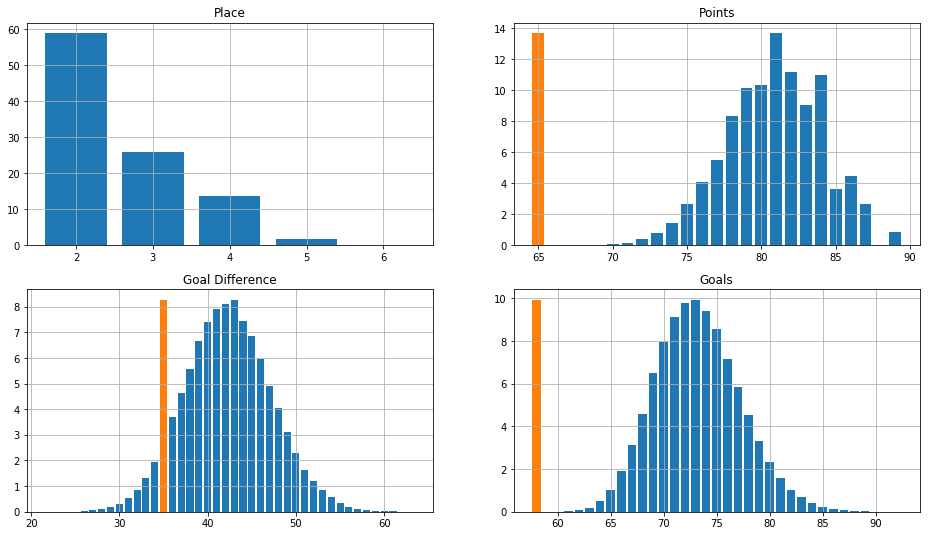

In [14]:
PremierLeague=League['EN']
PremierLeague.team_report('Man United')

# Most important matches

array([98.396     , 98.9610098 , 94.29165704, 96.61913672])

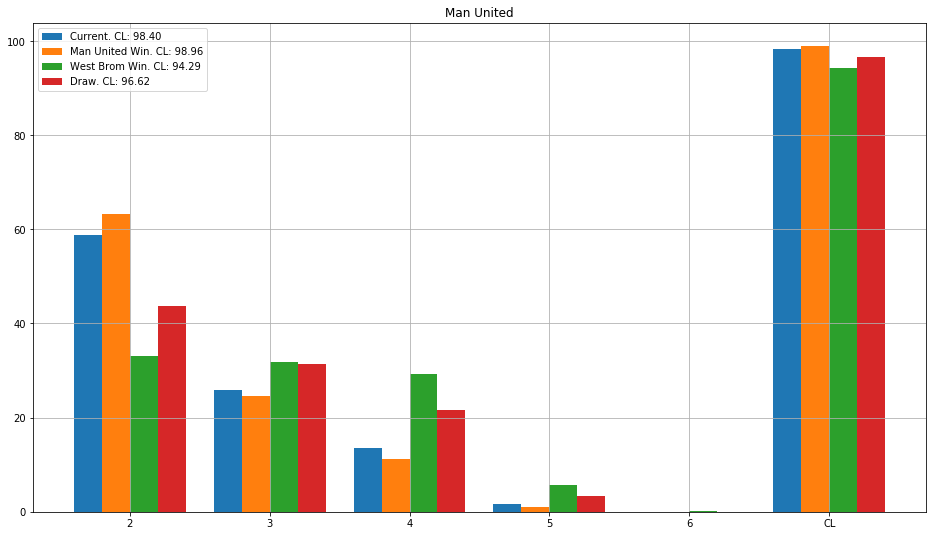

In [35]:
imp=[]
ref_team='Man United'
#ref_team='Liverpool'
#ref_team='Arsenal'
matches=[]
for x in PremierLeague.matches_to_sim:
    matches.append(x)
    pcl=PremierLeague.what_if(x,ref_team=ref_team,show_plot=False,place=4,or_better=True)
    #imp.append(pcl.max()/pcl.min())
    imp.append(pcl.std())
imp=np.array(imp)
matches=np.array(matches)
the_match=matches[imp.argmax()]
PremierLeague.what_if(the_match,ref_team=ref_team)

array([98.396     , 97.55892649, 99.22044047, 98.74001623])

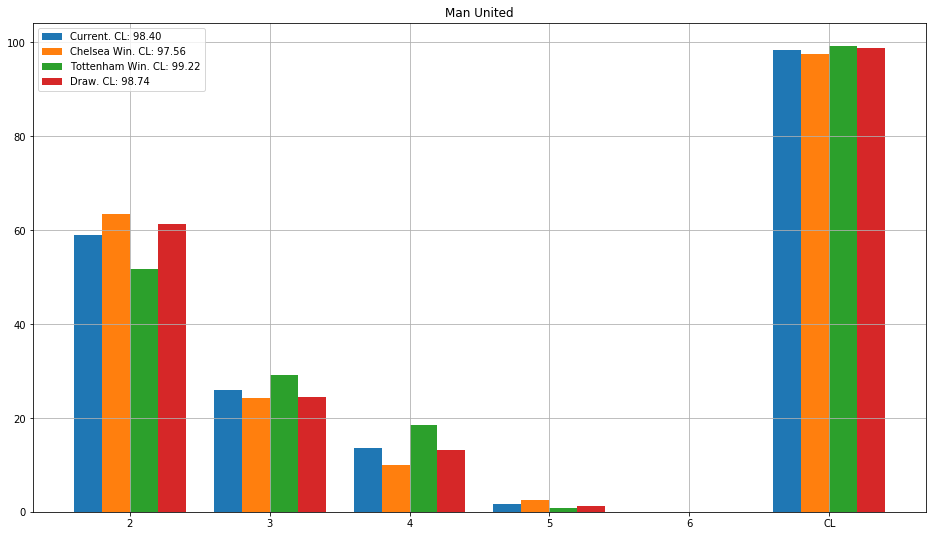

In [36]:
PremierLeague.what_if('Chelsea v Tottenham',ref_team=ref_team)

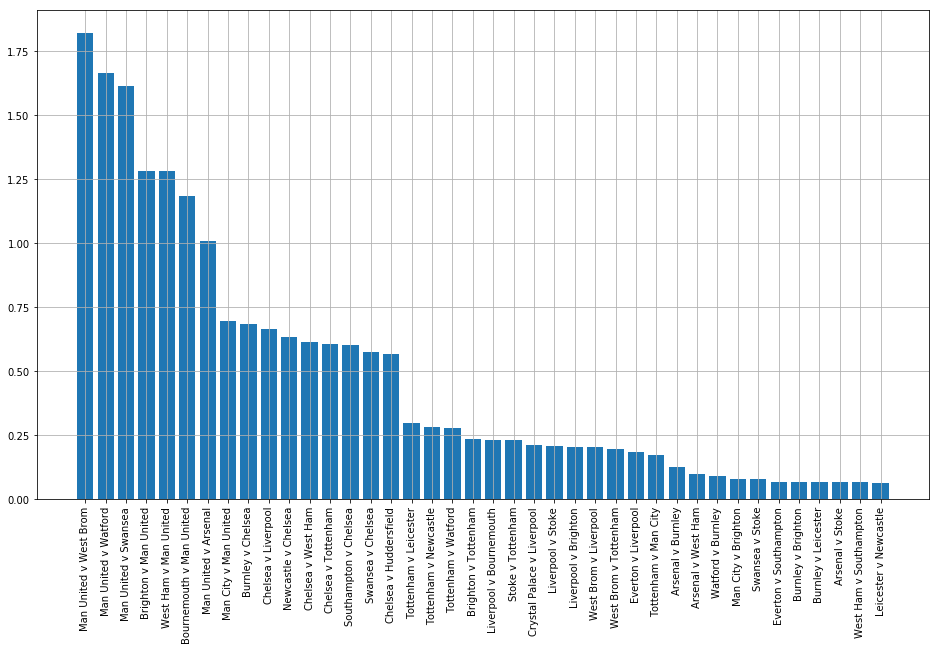

In [37]:
i_sort=(-imp).argsort()
matches=matches[i_sort]
imp=imp[i_sort]
xx=np.arange(40)
plt.bar(xx,imp[xx])
plt.xticks(xx,matches[xx],rotation=90);
plt.grid(True)

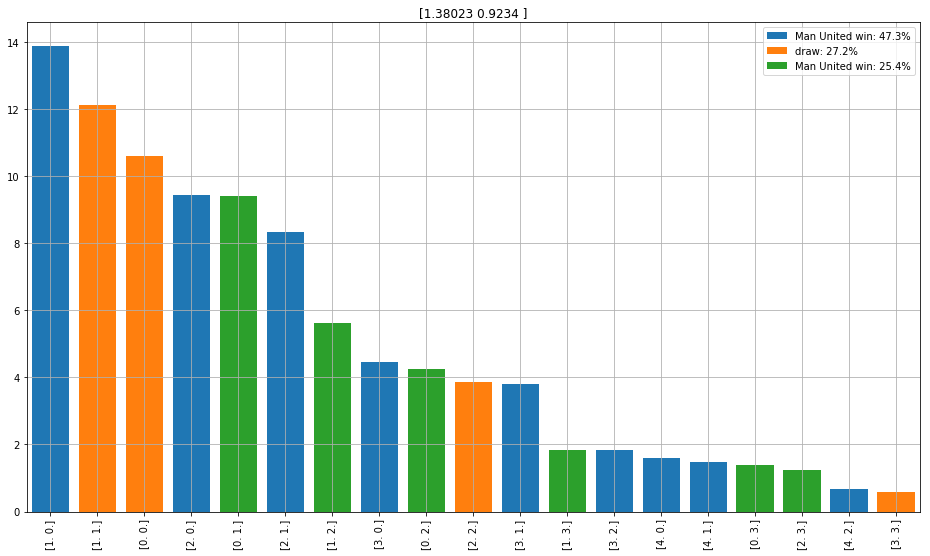

In [18]:
teams['Man United']+calibrator_1617.teams['Man United']

1.981035

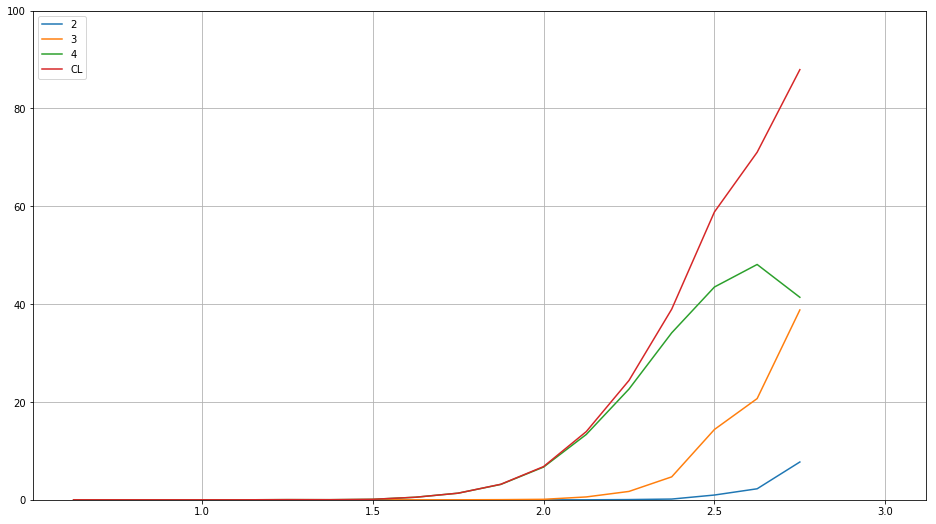

In [19]:
team_name='Man United'
#team_name='Tottenham'
team_name='Chelsea'
#team_name='Liverpool'
i=PremierLeague.team_id[team_name]
ind=PremierLeague.place_per_team[i,:]<=4
tmp=[PremierLeague.matches_to_sim[x] for x in PremierLeague.matches_to_sim ]
n=len([x for x in tmp if x['Home']==team_name or x['Away']==team_name])
#pnts=PremierLeague.points_per_team[i,ind]-PremierLeague.current_points['Man United']
pnts=PremierLeague.points_per_team[i,:]-PremierLeague.current_points[team_name]
plc=PremierLeague.place_per_team[i,:]

nrpnts=np.arange(5,3*n+1)
p=np.zeros([nrpnts.shape[0],5])
p[:]=np.nan
for jj in range(nrpnts.shape[0]):
    ind=pnts==nrpnts[jj]
    if ind.any():
        p[jj,0]=(plc[ind]==2).sum()/ind.sum()
        p[jj,1]=(plc[ind]==3).sum()/ind.sum()
        p[jj,2]=(plc[ind]==4).sum()/ind.sum()
        p[jj,3]=(plc[ind]<=4).sum()/ind.sum()
    

plt.plot(nrpnts/n,100*p[:,0],label='2')
plt.plot(nrpnts/n,100*p[:,1],label='3')
plt.plot(nrpnts/n,100*p[:,2],label='4')
plt.plot(nrpnts/n,100*p[:,3],label='CL')
plt.legend()
plt.grid(True)
plt.ylim([0,100])
#plt.xlabel([0,3])
pnts.mean()/n